# Model Selection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from pricing.benchmark import Benchmark
from pricing.models.preprocessing import build_model

import warnings

warnings.filterwarnings("ignore")

In [2]:
file_path = 'data/export.xlsx'
df = pd.read_excel(file_path, index_col=0)
X = df.drop(['Bag_Purchased', 'bag_base_price'], axis=1)
y = df['Bag_Purchased']

## Use the preprocessing pipeline to gain insights to the most relevant features

In [3]:
pl = build_model(imputer=True, engineered=True, interactions=True, scaler=True, dim_reduction="svd").set_params(svd__n_components=20)

In [4]:
pl.fit(X, y)

# This is the structure of the most general preprocessing pipeline we will use

Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['airlines', 'partner',
                                                   'market_group']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['distance',
                                                   'est_dst_temperature',
                                                   'src_dst_gdp',
                                                   'bag_total_price',
                                                   'children', 'bag_weight',
                                                   'nr_of_stopovers',
                                                   'passengers',
                                                   'is_intercontinental',
                                                   'within_country',
                                                   'us_m...
                                                   'travel_time', 'price',
                                                   'children', 'bag_weight',
                                                   'nr_of_stopovers',
                                                   'passengers',
                                                   'is_intercontinental',
                                                   'within_country',
                                                   'us_movement_outside_us',
                                                   'price_ratio',
                                                   'log_grp_ratio',
                                                   'log_distance', 'log_price',
                                                   'log_travel_time',
                                                   'log_src_dst_gdp',
                                                   'log_passengers'])],
                                   verbose_feature_names_out=False)),
                ('scaler', StandardScaler()),
                ('svd', TruncatedSVD(n_components=20))])

In [5]:
# Use the SVD to determine the features with highest contribution to the largest singular values

svd = pl.named_steps.svd
columns = svd.feature_names_in_
index = svd.get_feature_names_out()

svd_df = pd.DataFrame(svd.components_, index=index, columns=columns)

Text(0.5, 1.0, 'Contribution to leading 30 singular vectors')

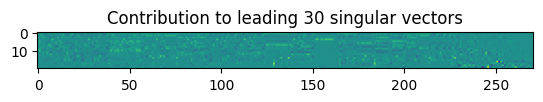

In [6]:
fig = plt.imshow(svd_df)
fig.axes.set_title("Contribution to leading 30 singular vectors")

market_group_market2                      0.054430
bag_weight within_country                 0.054564
children log_src_dst_gdp                  0.054868
bag_total_price log_src_dst_gdp           0.054939
src_dst_gdp us_movement_outside_us        0.055158
us_movement_outside_us log_grp_ratio      0.055158
us_movement_outside_us log_src_dst_gdp    0.055623
bag_weight log_distance                   0.055746
is_intercontinental log_src_dst_gdp       0.056014
is_intercontinental price_ratio           0.056411
passengers log_src_dst_gdp                0.057331
booking_window_group_0 - 3 days           0.057574
bag_weight                                0.057626
bag_weight^2                              0.057786
partner_partner2                          0.058119
partner_partner1                          0.058119
bag_weight log_price                      0.058140
log_src_dst_gdp^2                         0.058335
log_src_dst_gdp log_passengers            0.058841
passengers is_intercontinental 

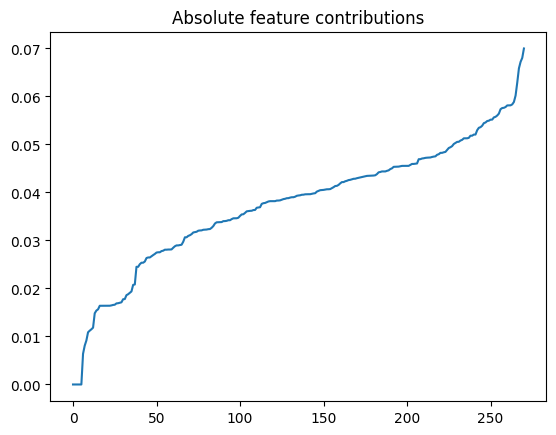

In [7]:
features = svd_df.abs().mean().sort_values() 

fig = plt.plot(features.values)
plt.title("Absolute feature contributions")

features.tail(25)

## Explore the performance of the different preprocessing steps

In [8]:
# The simplest regression model 
baseline = build_model(model=LogisticRegression())

# LR with Linear Regression imputation for ticket price
LR_imputed = build_model(imputer=True, engineered=False, interactions=False, scaler=False, model=LogisticRegression())
LR_imputed.set_params(classifier__max_iter=1000, classifier__penalty='l1', classifier__solver='liblinear')

# LR with some feature engineering (log of highly skewed variables and bag/ticket price ratio)
LR_eng = build_model(imputer=False, engineered=True, interactions=False, model=LogisticRegression())
LR_eng.set_params(classifier__max_iter=1000, classifier__penalty='l1', classifier__solver='liblinear')

# LR with second order interactions among variables
LR_interactions = build_model(imputer=False, engineered=False, interactions=True, model=LogisticRegression())
LR_interactions.set_params(classifier__max_iter=1000, classifier__penalty='l1', classifier__solver='liblinear')

# LR with LR imputation, engineered features, second order interactions and feature selection by Latent Semantic Analysis (SVD)
LR_feature_select = build_model(imputer=True, engineered=True, interactions=True, features=features.tail(30).index.values, model=LogisticRegression())
LR_feature_select.set_params(classifier__class_weight='balanced', classifier__solver='liblinear')

# LR with interactions and LSA
LR_svd = build_model(imputer=False, engineered=False, interactions=True, dim_reduction="svd", model=LogisticRegression())
LR_svd.set_params(classifier__class_weight='balanced')

# K-best feature selection using ANOVA
LR_kbest = build_model(imputer=False, engineered=False, interactions=True, dim_reduction='kbest', model=LogisticRegression())
LR_kbest.set_params(classifier__class_weight='balanced', classifier__solver='liblinear')

# Principal Component Analysis
LR_pca = build_model(imputer=False, engineered=False, interactions=True, dim_reduction='pca', model=LogisticRegression())
LR_pca.set_params(classifier__class_weight='balanced', classifier__penalty='l1', classifier__solver='liblinear')


models={
    'baseline': baseline,
    'LR_imputed': LR_imputed,
    'LR_eng': LR_eng,
    'LR_interactions': LR_interactions,
    'LR_feature_select': LR_feature_select,
    'LR_kbest': LR_kbest,
    'LR_svd': LR_svd,
    'LR_pca': LR_pca,
}

In [9]:
benchmark = Benchmark(models=models)
scores = benchmark.evaluate()
scores

  0%|          | 0/8 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

,ROC-AUC Score
LR_eng,0.775005
LR_interactions,0.774370
LR_imputed,0.766042
LR_kbest,0.744490
baseline,0.742510
LR_pca,0.732397
LR_svd,0.712461
LR_feature_select,0.704422


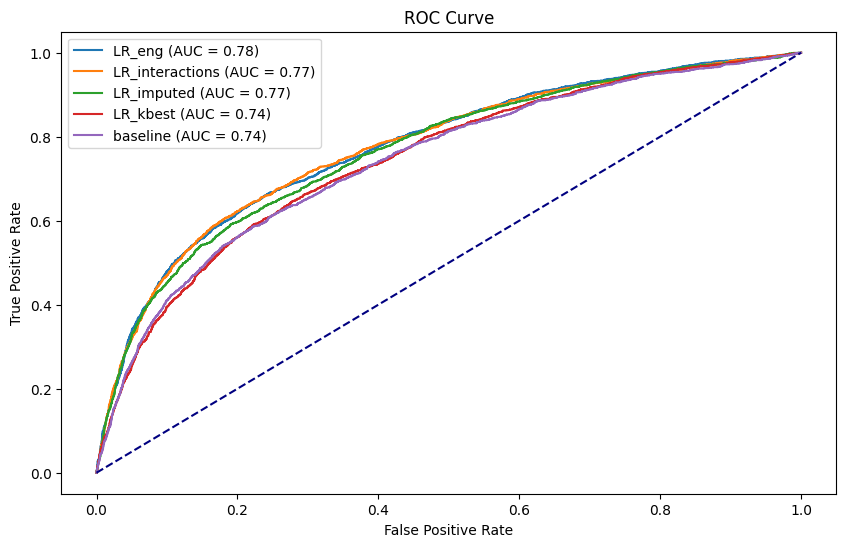

In [10]:
# Plot the performance of all models doing better than the baseline
benchmark.roc_auc_plot(models=scores[:'baseline'].index)

It seems that feature engineering, interactions, linear regression imputation and ANOVA $f$-statistic selection are the best choices

In [11]:
models['LR_best'] = build_model(imputer=True, engineered=True, interactions=True, dim_reduction='kbest', model=LogisticRegression())
models['LR_best'].set_params(classifier__max_iter=1000, classifier__penalty='l1', classifier__solver='liblinear')

benchmark = Benchmark(models=models)
benchmark.evaluate()

  0%|          | 0/9 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

,ROC-AUC Score
LR_eng,0.775081
LR_interactions,0.774372
LR_imputed,0.766031
LR_best,0.749454
LR_kbest,0.744490
baseline,0.742510
LR_pca,0.732407
LR_svd,0.713016
LR_feature_select,0.704422


Not really better. Let's try with sample balancing

In [12]:
models = {
    'LR_eng': LR_eng,
    'baseline': baseline,
    'LR_eng_balanced': build_model(imputer=True, engineered=True, interactions=False, model=LogisticRegression())
}
models['LR_eng_balanced'].set_params(
    classifier__max_iter=1000, 
    classifier__penalty='l1', 
    classifier__solver='liblinear', 
    classifier__class_weight='balanced'
)

bm = Benchmark(models=models)
bm.evaluate()

  0%|          | 0/3 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

,ROC-AUC Score
LR_eng,0.774932
LR_eng_balanced,0.771437
baseline,0.742510


Not better. No need to balance weights

## Test different regression techniques beyond Logistic Regression

In [13]:
models['GB'] = build_model(imputer=False, engineered=True, interactions=False, model=GradientBoostingClassifier())
models['GB_interactions'] = build_model(imputer=False, engineered=True, interactions=True, model=GradientBoostingClassifier())
models['SVM'] = build_model(imputer=False, engineered=True, interactions=False, model=SVC(probability=True))
models['NB'] = build_model(imputer=False, engineered=True, interactions=False, model=GaussianNB())

In [14]:
bm = Benchmark(models=models)
bm.evaluate()

  0%|          | 0/7 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

Cross-validation:   0%|          | 0/5 [00:00<?, ?it/s]

,ROC-AUC Score
GB,0.782323
GB_interactions,0.782022
LR_eng,0.775048
LR_eng_balanced,0.771452
baseline,0.742510
NB,0.734470
SVM,0.562735


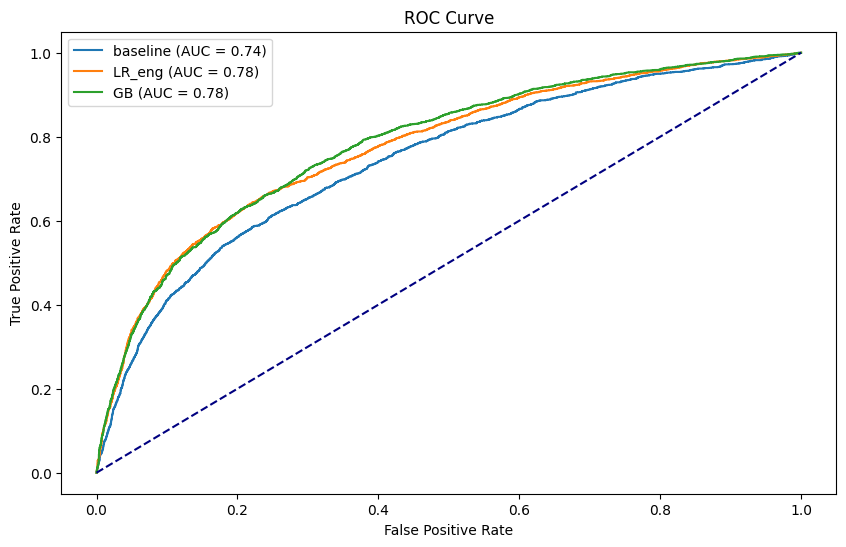

In [15]:
bm.roc_auc_plot(models=['baseline', 'LR_eng', 'GB'])

**The best model is Gradient Boosting with engineered features**

Slight improvement above .3 FPR 

In [16]:
models['GB']

Pipeline(steps=[('imputer',
                 ColumnTransformer(transformers=[('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['airlines',
                                                   'booking_window_group',
                                                   'partner', 'market_group']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['distance',
                                                   'est_dst_temperature',
                                                   'src_dst_gdp',
                                                   'bag_total_price',
                                                   'travel_time', 'price',
                                                   'children', 'bag_weight',
                                                   'nr_of_stopovers',
                                                   'passengers'...
                                                  ['airlines',
                                                   'booking_window_group',
                                                   'partner',
                                                   'market_group'])],
                                   verbose_feature_names_out=False)),
                ('engineered',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('precompute', ExtraFeatures(),
                                                  ['bag_total_price',
                                                   'distance', 'price',
                                                   'travel_time', 'src_dst_gdp',
                                                   'passengers'])],
                                   verbose_feature_names_out=False)),
                ('classifier', GradientBoostingClassifier())])